# **NOTE**
# Val_accuracy has a maximum of 75% 
(changing network architecture won't work);<br>
Because (after data investigation) I found that many samples are misclassifed & some samples are corrupted (face recognition & preprocessing issues)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from PIL import ImageFile
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('INFO')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


2021-10-25 22:11:11.277379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    horizontal_flip = True,
                                    brightness_range=(0.8,1.2)
                                    )

test_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    brightness_range=(0.8,1.2),
                                    horizontal_flip = True,
                                    )


training_set = train_datagen.flow_from_directory(
                                                 '../input/faceshape-processed/dataset/train',
                                                 target_size = (250,190),
                                                 batch_size = 64,
                                                 color_mode = 'grayscale',
                                                 shuffle = True,
                                                 class_mode = 'categorical'
                                                 )

test_set = test_datagen.flow_from_directory(
                                            '../input/faceshape-processed/dataset/test',
                                            target_size = (250,190),
                                            batch_size = 64,
                                            color_mode = 'grayscale',
                                            shuffle=True,
                                            class_mode = 'categorical'
                                            )

Found 3981 images belonging to 5 classes.
Found 998 images belonging to 5 classes.


In [3]:
# Build model

model = Sequential()
model.add(Conv2D(8, (7, 7), activation='selu', padding="valid", input_shape=(250,190,1)))
model.add(Conv2D(8, (5, 5), activation='selu', padding="valid"))
model.add(MaxPooling2D(pool_size=(5,5),padding="valid", strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(3,3),padding="valid", strides=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='selu'))
model.add(Dense(5, activation="softmax"))

model.summary()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

2021-10-25 22:11:15.752297: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-25 22:11:15.755326: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-25 22:11:15.792743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-25 22:11:15.793437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-25 22:11:15.793506: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-25 22:11:15.819189: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 244, 184, 8)       400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 180, 8)       1608      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 118, 88, 8)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 43, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 19952)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              20431872  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5

In [4]:
X_train, y_train = next(training_set)
X_test, y_test = next(test_set)

2021-10-25 22:11:18.419083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-25 22:11:18.431181: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz
2021-10-25 22:11:18.573837: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-25 22:11:19.357152: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-25 22:11:19.365008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


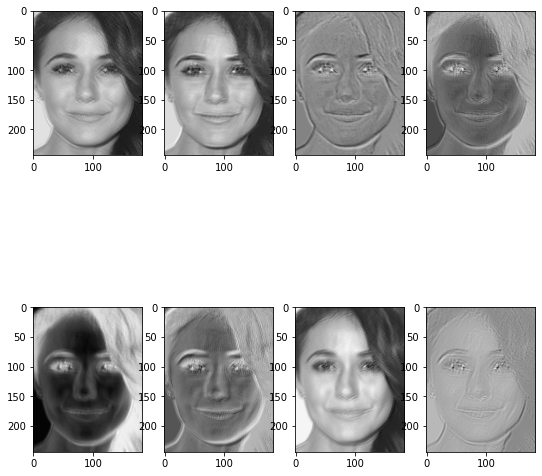

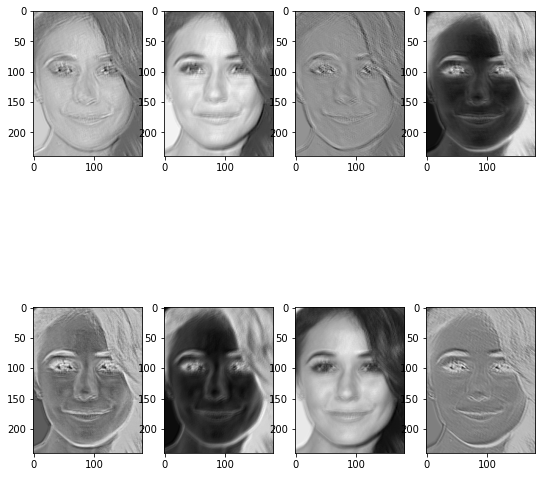

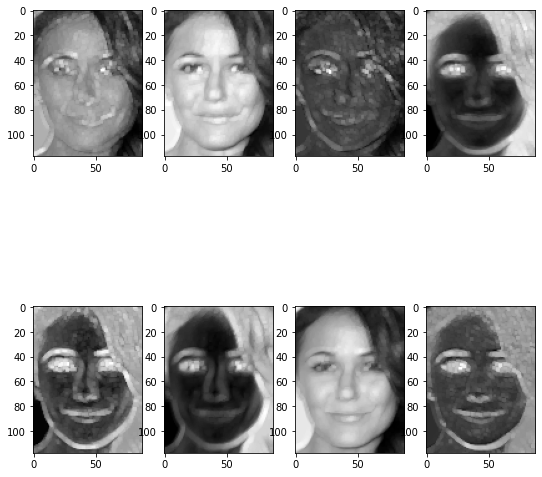

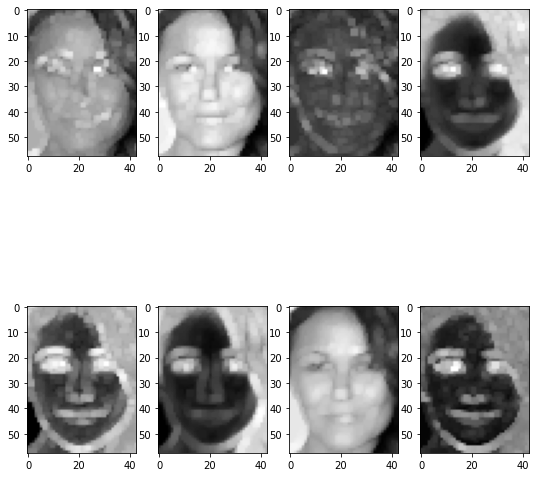

In [5]:
# Visualize convolution processing
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[0].reshape(1,250,190,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*4.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
col_size = 4
row_size = 2
n_layers = 4
for layer_index in range(n_layers):#(len(model.layers)-10):
    display_activation(activations, col_size, row_size, layer_index)

In [6]:
# Custom early stop
class ValAccEarlyStop(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ValAccEarlyStop, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [7]:
# Training phase
history = model.fit(
                             training_set,
                             epochs = 50,
                             validation_data = test_set,
                             shuffle = True,
                            callbacks=[
                                 ValAccEarlyStop(0.73)
                             ]
                            )

Epoch 1/50
63/63 [==============================] - 19s 282ms/step - loss: 15.6820 - accuracy: 0.2457 - val_loss: 1.5113 - val_accuracy: 0.3607
Epoch 2/50
63/63 [==============================] - 8s 132ms/step - loss: 1.4057 - accuracy: 0.4170 - val_loss: 1.2405 - val_accuracy: 0.5050
Epoch 3/50
63/63 [==============================] - 9s 137ms/step - loss: 1.2534 - accuracy: 0.4710 - val_loss: 1.1757 - val_accuracy: 0.5341
Epoch 4/50
63/63 [==============================] - 8s 134ms/step - loss: 1.1721 - accuracy: 0.5230 - val_loss: 1.1479 - val_accuracy: 0.5230
Epoch 5/50
63/63 [==============================] - 8s 134ms/step - loss: 1.1373 - accuracy: 0.5428 - val_loss: 1.2199 - val_accuracy: 0.5080
Epoch 6/50
63/63 [==============================] - 8s 132ms/step - loss: 1.0886 - accuracy: 0.5644 - val_loss: 1.1711 - val_accuracy: 0.5491
Epoch 7/50
63/63 [==============================] - 9s 140ms/step - loss: 1.0645 - accuracy: 0.5696 - val_loss: 1.0370 - val_accuracy: 0.5852
Epoc

In [8]:
# Evaluate Model
scoreSeg = model.evaluate_generator(test_set)
print("Accuracy = ",scoreSeg[1])

Accuracy =  0.7214428782463074


In [9]:
model.save("face-shape-recognizer.h5")

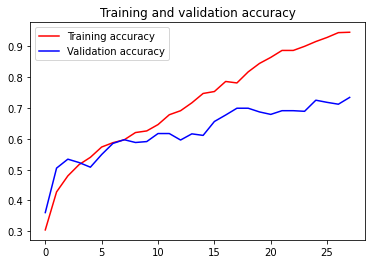

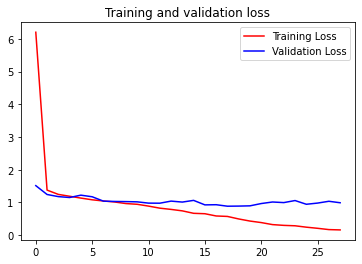

In [10]:
# Visualize Loss & Accuracy

%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

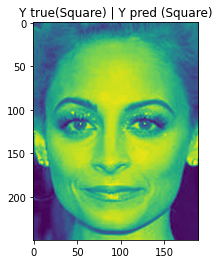

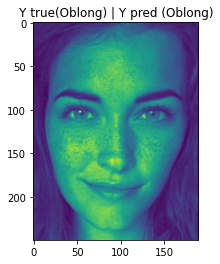

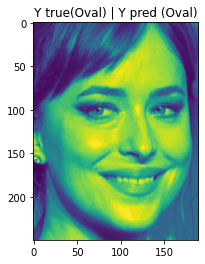

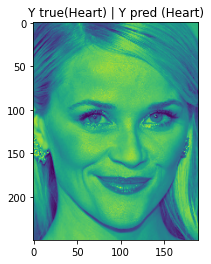

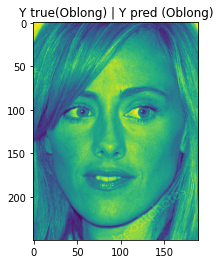

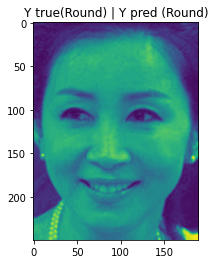

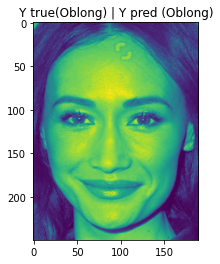

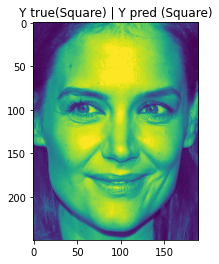

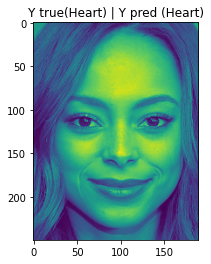

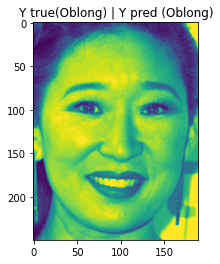

In [11]:
# Make some predictions on training data

from tensorflow.keras.preprocessing import image

labels = list(training_set.class_indices)

for i in np.random.randint(X_train.shape[0], size=10):
    img = image.img_to_array(X_train[i])
    img = np.expand_dims(img, axis=0)
    images = np.vstack([img])
    y_pred = np.argmax(model.predict(img,verbose=0), axis=1)[0]
    y_true = np.argmax(y_train[i])
    plt.imshow(X_train[i])
    plt.title(f"Y true({labels[y_true]}) | Y pred ({labels[y_pred]})")
    plt.show()